In [7]:
import fastai.vision.all as vision
# from fastbook import *
import numpy as np
from PIL import Image
from sklearn import datasets
import seaborn as sns
import sklearn
import torch

from meanclassifier import MeanClassifier
from gradientdescentregressor import GradientDescentRegressor

In [2]:
def image_to_tensor(img_file):
    img = Image.open(img_file)
    as_array = np.array(img)
    as_tensor = torch.from_numpy(as_array)
    return as_tensor

In [3]:
path = vision.untar_data(vision.URLs.MNIST_SAMPLE)

train_threes = (path/'train'/'3').ls().sorted()
train_threes = [image_to_tensor(img) for img in train_threes]
train_threes = torch.stack(train_threes).float() / 255

train_sevens = (path/'train'/'7').ls().sorted()
train_sevens = [image_to_tensor(img) for img in train_sevens]
train_sevens = torch.stack(train_sevens).float() / 255

test_threes = (path/'valid'/'3').ls().sorted()
test_threes = [image_to_tensor(img) for img in test_threes]
test_threes = torch.stack(test_threes).float() / 255

test_sevens = (path/'valid'/'7').ls().sorted()
test_sevens = [image_to_tensor(img) for img in test_sevens]
test_sevens = torch.stack(test_sevens).float() / 255

X_train = torch.cat((train_sevens, train_threes))
y_train = torch.from_numpy(np.array([0] * len(train_sevens) + [1] * len(train_threes)))

X_test = torch.cat((test_sevens, test_threes))
y_test = torch.from_numpy(np.array([0] * len(test_sevens) + [1] * len(test_threes)))


mae: 0.9514229893684387
mse: 0.9661432504653931


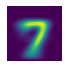

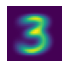

In [4]:
mae_clf = MeanClassifier(metric='mae')
mae_clf.fit(X_train, y_train)
mae_clf.show_means()

mse_clf = MeanClassifier(metric='mse')
mse_clf.fit(X_train, y_train)
print(f'mae: {mae_clf.score(X_test, y_test)}')
print(f'mse: {mse_clf.score(X_test, y_test)}')

<AxesSubplot:>

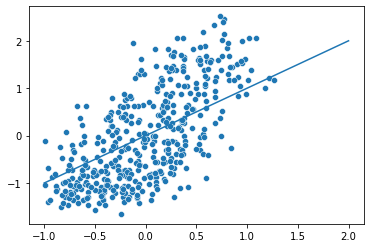

In [9]:
X, y = datasets.load_diabetes(return_X_y=True)
y = sklearn.preprocessing.StandardScaler().fit_transform(y.reshape(-1, 1))[:, 0]
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

reg = GradientDescentRegressor(epochs=10000)
reg.fit(X, y)
predictions = reg.predict(X)
sns.scatterplot(x=predictions.detach().numpy(), y=y)
sns.lineplot(x=range(-1, 3), y=range(-1, 3))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d3089e79-0e42-40a4-9bfd-5171fd4144aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>